In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from itertools import product
from typing import List
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 10

if "ipykernel_launcher.py" in sys.argv[0]:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

colors = ["#5C49AC", "#1F9BCE", "#00B5CA", "#BED45F", "#F9E03B"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

from main import *

In [2]:
J = 1
agnetsCount = 500
Fs = np.linspace(0, 5, 30)
Ks = np.sort(np.concatenate([np.linspace(-1, 1, 30), [0]]))
# Ks = np.linspace(-1, 1, 30)
TNum = 500

targetPath = f"./data/u1wLastStateJ{J}.h5"
# targetPath = f"./data/lastStateJ{J}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionXs")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseThetas")

modelNums = totalPositionX.shape[0] // agnetsCount

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionXs = dict()
phaseThetas = dict()

models = [
    MobileDrive(agentsNum=500, K=K, J=J, F=F, dt=0.02) 
    for F in Fs
    for K in Ks
]
for model in tqdm(models):
    
    model.positionX = totalPositionX[idx]
    model.phaseTheta = totalPhaseTheta[idx]
    model.counts = 9990
    model.update_temp()
    t = (model.counts) * model.dt
    model.drivePosition = np.array([
        model.druveRadiusR * np.cos(model.driveAngularVelocityW * t),
        model.druveRadiusR * np.sin(model.driveAngularVelocityW * t)
    ])
    idx += 1

del totalPositionX, totalPhaseTheta

  0%|          | 0/930 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


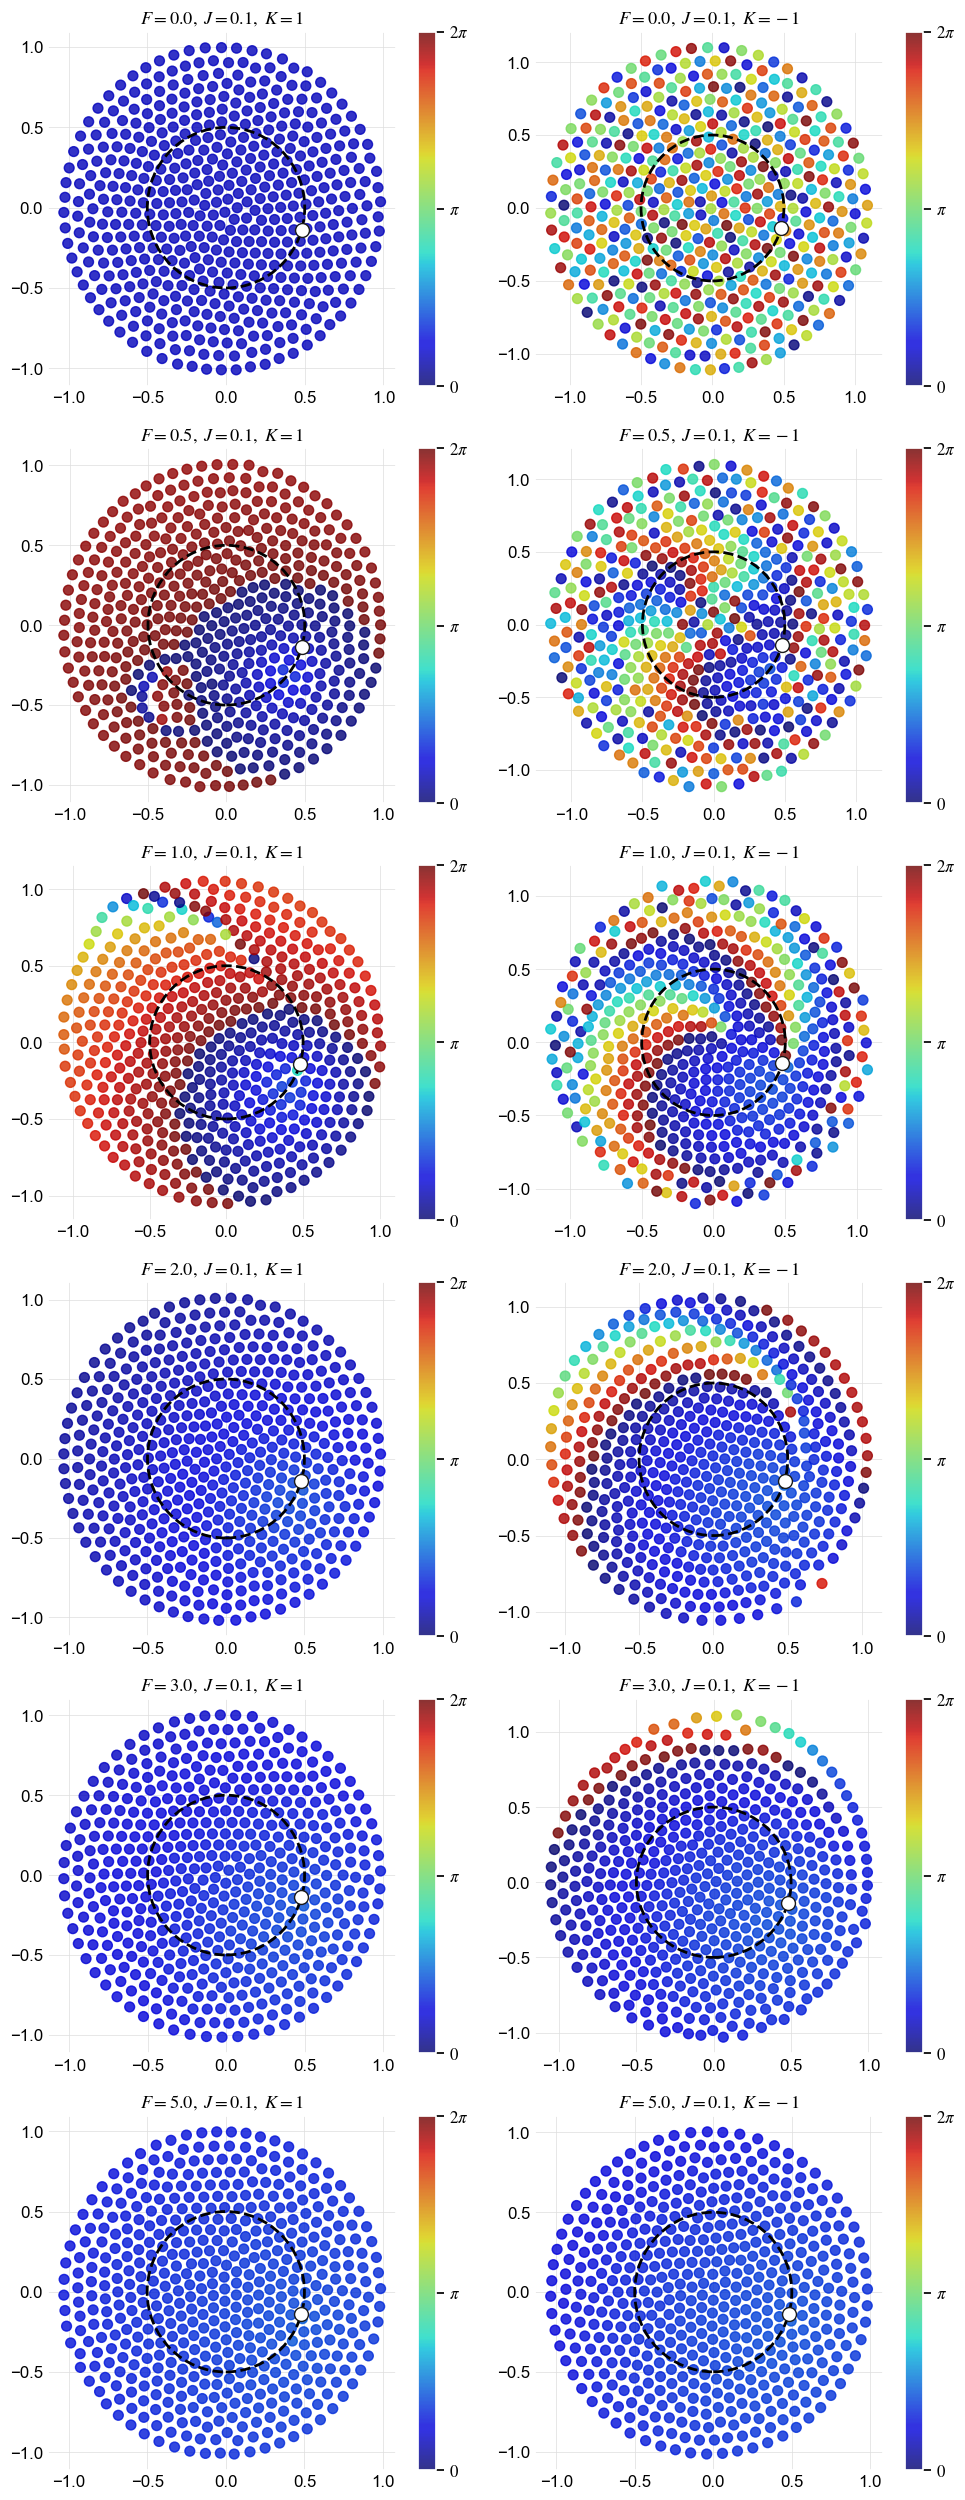

In [3]:
# For J=0.1
sns.set_theme(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

selectedF = [Fs[0], Fs[3], Fs[6], Fs[12], Fs[17], Fs[29]]
selectedFNum = len(selectedF)
selectedK = [1, -1]

fig, axs = plt.subplots(selectedFNum, 2, figsize=(10, selectedFNum * 4.2))
for row, F in enumerate(selectedF):
    for col, K in enumerate(selectedK):
        model = [m for m in models if m.F == F and m.K == K][0]
        model.update()
        ax = axs[row, col]
        ax.tick_params(direction='in', length=3)

        StateAnalysis.plot_last_state(model, ax)
        
        FinTitle = np.round(F) if F > 0.6 else np.round(F, 1)
        ax.set_title(f"$F={FinTitle:.1f},\ J={J},\ K={K}$")
        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])


plt.tight_layout()
plt.savefig(f"./figs/formal/eps/snapshotJ{J}.eps", bbox_inches='tight')
plt.savefig(f"./figs/formal/png/snapshotJ{J}.png", bbox_inches='tight', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


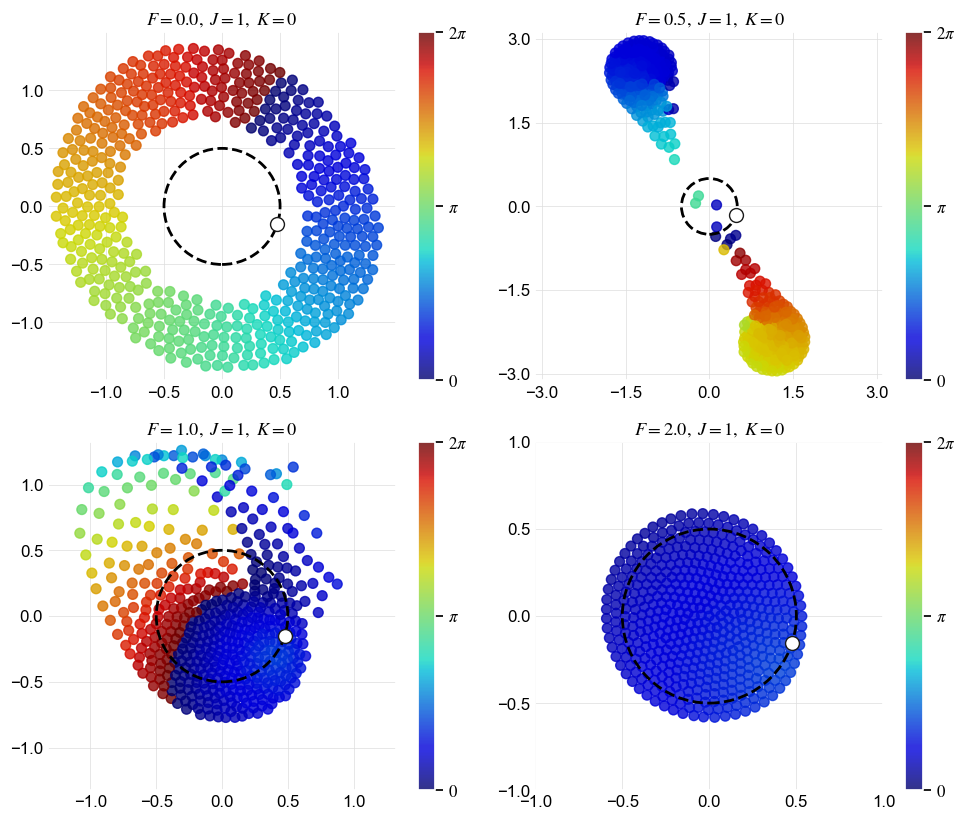

In [28]:
# For J = 1
sns.set_theme(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'

selectedF = [Fs[0], Fs[3], Fs[6], Fs[12]]
selectedFNum = len(selectedF)
selectedK = [0]

fig, axs = plt.subplots(2, 2, figsize=(10, 2 * 4.2))
for row, F in enumerate(selectedF):
    for col, K in enumerate(selectedK):
        model = [m for m in models if m.F == F and m.K == K][0]
        ax = axs.flatten()[row]
        ax.tick_params(direction='in', length=3)

        StateAnalysis.plot_last_state(model, ax)
        
        FinTitle = np.round(F) if F > 0.6 else np.round(F, 1)
        ax.set_title(f"$F={FinTitle:.1f},\ J={J},\ K={K}$")
        maxPos = np.abs(model.positionX).max()
        if maxPos < 1:
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_xticks([-1, -0.5, 0, 0.5, 1])
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        else:
            bound = maxPos * 1.05
            roundBound = np.round(bound)
            ax.set_xlim(-bound, bound)
            ax.set_ylim(-bound, bound)
            ax.set_xticks([-roundBound, -roundBound / 2, 0, roundBound / 2, roundBound])
            ax.set_yticks([-roundBound, -roundBound / 2, 0, roundBound / 2, roundBound])
        

plt.tight_layout()
plt.savefig(f"./figs/formal/eps/snapshotJ{J}K0.eps", bbox_inches='tight')
plt.savefig(f"./figs/formal/png/snapshotJ{J}K0.png", bbox_inches='tight', dpi=200)

In [3]:
maps4 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps4.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Vp(model)

maps1 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps1.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_R(model)

maps2 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in tqdm(models):
    maps2.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_Ptr(model)

maps3 = pd.DataFrame(index=Fs, columns=Ks, dtype=np.float64)
for model in models:
    maps3.loc[model.F, model.K] = StateAnalysis.calc_order_parameter_S(model)

  0%|          | 0/930 [00:00<?, ?it/s]

  0%|          | 0/930 [00:00<?, ?it/s]

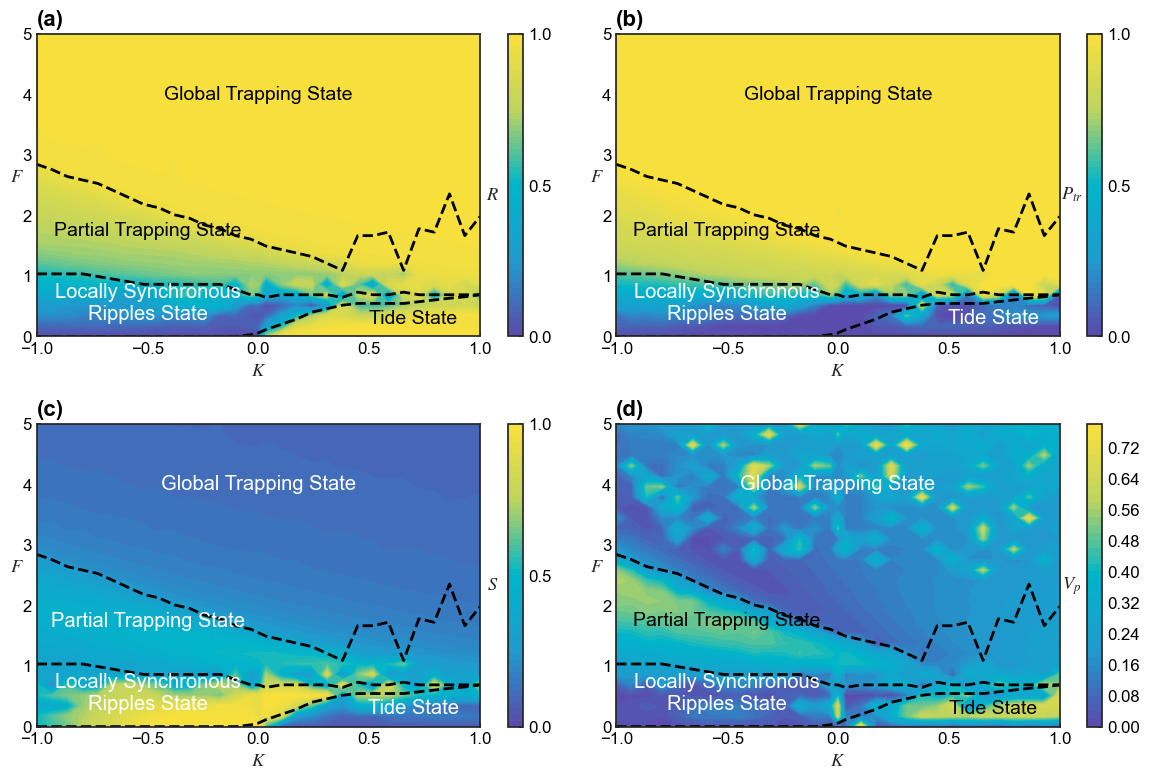

In [33]:
# For J=0.1
# get line1
Flocs = []
maps4Thres = 0.25
for K in Ks:
    selectedIdxs = maps4[(maps4[K] < maps4Thres) & (maps4[K].shift() >= maps4Thres) & (Fs > 1)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line1F = pd.Series(Flocs, index=Ks).rolling(3, center=True, min_periods=1).mean()
# get line2
Flocs = []
maps1Thres = 0.6
for K in Ks:
    reverseF = maps1[K][::-1]
    selectedIdxs = reverseF[(reverseF < maps1Thres) & (reverseF.shift() >= maps1Thres)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line2F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
# get line3
Flocs = []
maps1Thres = 0.6
for K in Ks:
    Fvalues = maps1[K]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line3F = pd.Series(Flocs, index=Ks).rolling(6, center=True, min_periods=1).mean()

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'


levels = 50

cf1 = ax1.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(False)
ax1.set_title("(a)", fontweight="bold", loc="left", fontsize=16)
cbar1 = plt.colorbar(cf1, ax=ax1, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(direction='in', length=3)
cbar1.set_label(r"$R$", fontweight="bold", rotation=0)
cbar1.ax.yaxis.set_label_coords(-1, 0.5)
ax1.plot(line1F, color='black', linestyle="--", lw=2)
ax1.plot(line2F, color='black', linestyle="--", lw=2)
ax1.plot(line3F, color='black', linestyle="--", lw=2)
ax1.text(0, 4, "Global Trapping State", fontsize=14, color="black", ha="center", va="center")
ax1.text(-0.5, 1.75, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax1.text(0.7, 0.3, "Tide State", fontsize=14, color="black", ha="center", va="center")
ax1.text(-0.5, 0.55, "Locally Synchronous\nRipples State", fontsize=14.5, color="white", ha="center", va="center")

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
stdMaps2.iloc[0, 1] = 1
cf2 = ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    stdMaps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    maps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.grid(False)
ax2.set_title("(b)", fontweight="bold", loc="left", fontsize=16)
cbar2 = plt.colorbar(cf2, ax=ax2, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(direction='in', length=3)
cbar2.set_label(r"$P_{tr}$", fontweight="bold", rotation=0)
cbar2.ax.yaxis.set_label_coords(-1, 0.5)
ax2.plot(line1F, color='black', linestyle="--", lw=2)
ax2.plot(line2F, color='black', linestyle="--", lw=2)
ax2.plot(line3F, color='black', linestyle="--", lw=2)
ax2.text(0, 4, "Global Trapping State", fontsize=14, color="black", ha="center", va="center")
ax2.text(-0.5, 1.75, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax2.text(0.7, 0.3, "Tide State", fontsize=14.5, color="white", ha="center", va="center")
ax2.text(-0.5, 0.55, "Locally Synchronous\nRipples State", fontsize=14.5, color="white", ha="center", va="center")

stdMaps3 = maps3.copy()
stdMaps3.iloc[0, 0] = 0
stdMaps3.iloc[0, 1] = 1
cf3 = ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    maps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.grid(False)
ax3.set_title("(c)", fontweight="bold", loc="left", fontsize=16)
cbar3 = plt.colorbar(cf3, ax=ax3, ticks=[0, 0.5, 1])
cbar3.ax.set_ylim(0, 1)
cbar3.ax.tick_params(direction='in', length=3)
cbar3.set_label(r"$S$", fontweight="bold", rotation=0)
cbar3.ax.yaxis.set_label_coords(-1, 0.5)
ax3.plot(line1F, color='black', linestyle="--", lw=2)
ax3.plot(line2F, color='black', linestyle="--", lw=2)
ax3.plot(line3F, color='black', linestyle="--", lw=2)
ax3.text(0, 4, "Global Trapping State", fontsize=14.5, color="white", ha="center", va="center")
ax3.text(-0.5, 1.75, "Partial Trapping State", fontsize=14.5, color="white", ha="center", va="center")
ax3.text(0.7, 0.3, "Tide State", fontsize=14.5, color="white", ha="center", va="center")
ax3.text(-0.5, 0.55, "Locally Synchronous\nRipples State", fontsize=14.5, color="white", ha="center", va="center")

cf4 = ax4.contourf(
    maps4.columns.values, maps4.index.values, 
    maps4.values, levels=levels, # vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax4.set_xticks([-1, -0.5, 0, 0.5, 1])
ax4.grid(False)
ax4.set_title("(d)", fontweight="bold", loc="left", fontsize=16)
cbar4 = plt.colorbar(cf4, ax=ax4)
cbar4.ax.tick_params(direction='in', length=3)
cbar4.set_label(r"$V_p$", fontweight="bold", rotation=0, loc="center")
cbar4.ax.yaxis.set_label_coords(-1, 0.5)
ax4.plot(line1F, color='black', linestyle="--", lw=2)
ax4.plot(line2F, color='black', linestyle="--", lw=2)
ax4.plot(line3F, color='black', linestyle="--", lw=2)
ax4.text(0, 4, "Global Trapping State", fontsize=14.5, color="white", ha="center", va="center")
ax4.text(-0.5, 1.75, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax4.text(0.7, 0.3, "Tide State", fontsize=14, color="black", ha="center", va="center")
ax4.text(-0.5, 0.55, "Locally Synchronous\nRipples State", fontsize=14.5, color="white", ha="center", va="center")

for ax in axs.flatten():
    ax.tick_params(direction='in', length=3)
    ax.set_ylabel(r"$F$", fontweight="bold", rotation=0)
    ax.set_xlabel(r"$K$", fontweight="bold")

plt.tight_layout()
plt.savefig(f"./figs/formal/eps/orderParameterMapJ{J}.eps", bbox_inches="tight")
plt.savefig(f"./figs/formal/png/orderParameterMapJ{J}.png", bbox_inches="tight", dpi=200)

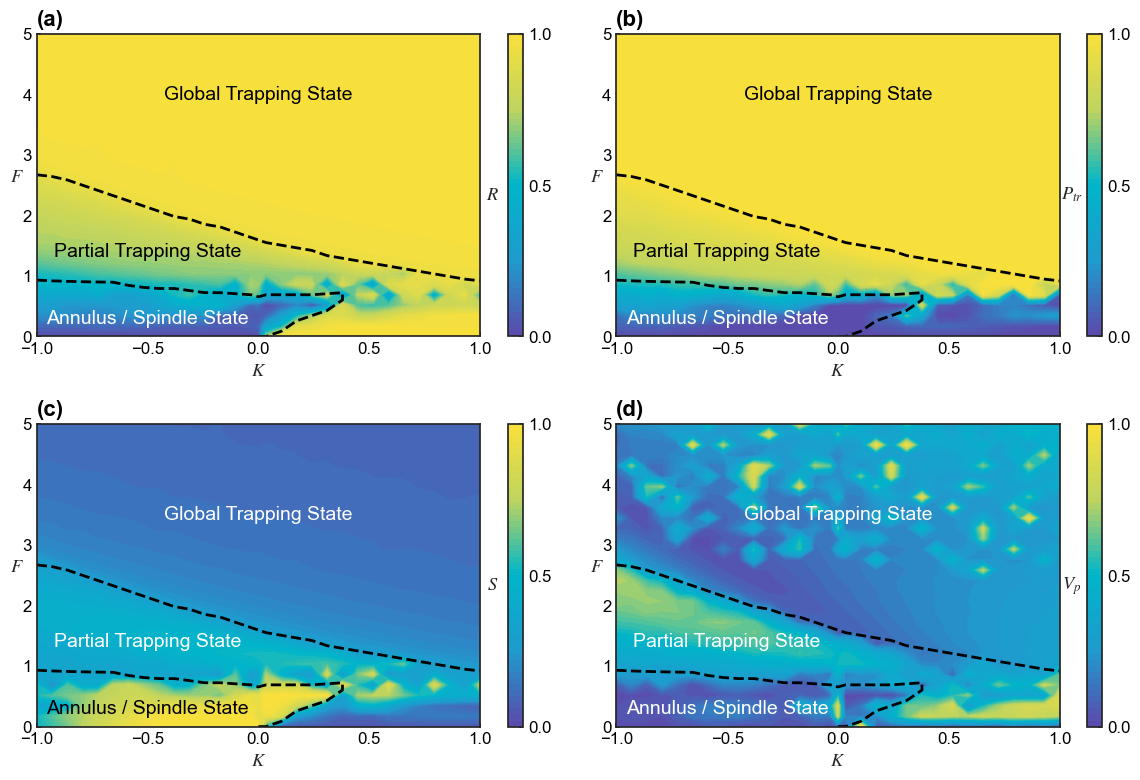

In [90]:
# For J=1
# get line1
Flocs = []
maps4Thres = 0.95
for K in Ks:
    reverseF = maps1[K][::-1]
    selectedIdxs = reverseF[(reverseF < maps4Thres) & (reverseF.shift() >= maps4Thres)].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line1F = pd.Series(Flocs, index=Ks).rolling(4, center=True, min_periods=1).mean()
# get line2
Flocs = []
maps1Thres = 0.55
for K in Ks:
    Fvalues = maps1[K][::-1]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line2F = pd.Series(Flocs, index=Ks).rolling(10, center=True, min_periods=1).mean()
line2F = line2F.iloc[:22]
# get line3
Flocs = []
maps1Thres = 0.8
for K in Ks:
    Fvalues = maps1[K]
    selectedIdxs = Fvalues[Fvalues < maps1Thres].index
    if len(selectedIdxs) > 0:
        locF = selectedIdxs[0]
    Flocs.append(locF)
line3F = pd.Series(Flocs, index=Ks).rolling(2, center=True, min_periods=1).mean()
line3F = line3F.iloc[:22]
line2F = pd.concat([line2F, line3F[::-1]]).iloc[:-15]

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'


levels = 50

cf1 = ax1.contourf(
    maps1.columns.values, maps1.index.values, 
    maps1.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
ax1.grid(False)
ax1.set_title("(a)", fontweight="bold", loc="left", fontsize=16)
cbar1 = plt.colorbar(cf1, ax=ax1, ticks=[0, 0.5, 1])
cbar1.ax.tick_params(direction='in', length=3)
cbar1.set_label(r"$R$", fontweight="bold", rotation=0)
cbar1.ax.yaxis.set_label_coords(-1, 0.5)
ax1.plot(line1F, color='black', linestyle="--", lw=2)
ax1.plot(line2F, color='black', linestyle="--", lw=2)
ax1.text(0, 4, "Global Trapping State", fontsize=14, color="black", ha="center", va="center")
ax1.text(-0.5, 1.4, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax1.text(-0.5, 0.3, "Annulus / Spindle State", fontsize=14, color="white", ha="center", va="center")

stdMaps2 = maps2.copy()
stdMaps2.iloc[0, 0] = 0
stdMaps2.iloc[0, 1] = 1
cf2 = ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    stdMaps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.contourf(
    maps2.columns.values, maps2.index.values, 
    maps2.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax2.set_xticks([-1, -0.5, 0, 0.5, 1])
ax2.grid(False)
ax2.set_title("(b)", fontweight="bold", loc="left", fontsize=16)
cbar2 = plt.colorbar(cf2, ax=ax2, ticks=[0, 0.5, 1])
cbar2.ax.tick_params(direction='in', length=3)
cbar2.set_label(r"$P_{tr}$", fontweight="bold", rotation=0)
cbar2.ax.yaxis.set_label_coords(-1, 0.5)
ax2.plot(line1F, color='black', linestyle="--", lw=2)
ax2.plot(line2F, color='black', linestyle="--", lw=2)
ax2.text(0, 4, "Global Trapping State", fontsize=14, color="black", ha="center", va="center")
ax2.text(-0.5, 1.4, "Partial Trapping State", fontsize=14, color="black", ha="center", va="center")
ax2.text(-0.5, 0.3, "Annulus / Spindle State", fontsize=14, color="white", ha="center", va="center")

stdMaps3 = maps3.copy()
stdMaps3.iloc[0, 0] = 0
stdMaps3.iloc[0, 1] = 1
cf3 = ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.contourf(
    maps3.columns.values, maps3.index.values, 
    maps3.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1
)
ax3.set_xticks([-1, -0.5, 0, 0.5, 1])
ax3.grid(False)
ax3.set_title("(c)", fontweight="bold", loc="left", fontsize=16)
cbar3 = plt.colorbar(cf3, ax=ax3, ticks=[0, 0.5, 1])
cbar3.ax.set_ylim(0, 1)
cbar3.ax.tick_params(direction='in', length=3)
cbar3.set_label(r"$S$", fontweight="bold", rotation=0)
cbar3.ax.yaxis.set_label_coords(-1, 0.5)
ax3.plot(line1F, color='black', linestyle="--", lw=2)
ax3.plot(line2F, color='black', linestyle="--", lw=2)
ax3.text(0, 3.5, "Global Trapping State", fontsize=14, color="white", ha="center", va="center")
ax3.text(-0.5, 1.4, "Partial Trapping State", fontsize=14, color="white", ha="center", va="center")
ax3.text(-0.5, 0.3, "Annulus / Spindle State", fontsize=14, color="black", ha="center", va="center")

stdMaps4 = maps4.copy()
stdMaps4.iloc[0, 0] = 0
stdMaps4.iloc[0, 1] = 1
cf4 = ax4.contourf(
    maps3.columns.values, maps3.index.values, 
    stdMaps4.values, levels=levels, vmin=0, vmax=1,
    cmap=cmap, alpha=1, zorder=0
)
dealtMaps4 = maps4.copy()
thres = 0.3
# dealtMaps4.iloc[10:] = dealtMaps4.iloc[10:].mask(dealtMaps4 > thres, thres)
ax4.contourf(
    maps4.columns.values, maps4.index.values, 
    dealtMaps4.values, levels=levels, # vmin=0, vmax=1,
    cmap=cmap, alpha=1, # zorder=10
)
ax4.set_xticks([-1, -0.5, 0, 0.5, 1])
ax4.grid(False)
ax4.set_title("(d)", fontweight="bold", loc="left", fontsize=16)
cbar4 = plt.colorbar(cf4, ax=ax4, ticks=[0, 0.5, 1])
cbar4.ax.tick_params(direction='in', length=3)
cbar4.set_label(r"$V_p$", fontweight="bold", rotation=0, loc="center")
cbar4.ax.yaxis.set_label_coords(-1, 0.5)
ax4.plot(line1F, color='black', linestyle="--", lw=2)
ax4.plot(line2F, color='black', linestyle="--", lw=2)
ax4.text(0, 3.5, "Global Trapping State", fontsize=14, color="white", ha="center", va="center")
ax4.text(-0.5, 1.4, "Partial Trapping State", fontsize=14, color="white", ha="center", va="center")
ax4.text(-0.5, 0.3, "Annulus / Spindle State", fontsize=14, color="white", ha="center", va="center")

for ax in axs.flatten():
    ax.tick_params(direction='in', length=3)
    ax.set_ylabel(r"$F$", fontweight="bold", rotation=0)
    ax.set_xlabel(r"$K$", fontweight="bold")

plt.tight_layout()
plt.savefig(f"./figs/formal/eps/orderParameterMapJ{J}.eps", bbox_inches="tight")
plt.savefig(f"./figs/formal/png/orderParameterMapJ{J}.png", bbox_inches="tight", dpi=200)

In [91]:
maps4

-1.000000  -0.931034  -0.862069  -0.793103  -0.724138  -0.655172  \
0.000000   0.014315   0.007273   0.007250   0.012452   0.021845   0.004708   
0.172414   0.021453   0.038909   0.031642   0.017554   0.060094   0.109387   
0.344828   0.019757   0.027665   0.049875   0.036296   0.047599   0.090669   
0.517241   0.004468   0.017464   0.007738   0.029301   0.043063   0.034481   
0.689655   0.050383   0.151049   0.048795   0.200262   0.092491   0.013791   
0.862069   0.199135   0.201723   0.214798   0.207176   0.213667   0.222038   
1.034483   0.249236   0.264614   0.276858   0.265966   0.270454   0.285705   
1.206897   0.304411   0.306777   0.323798   0.336893   0.356786   0.346515   
1.379310   0.363568   0.369630   0.382492   0.377750   0.387389   0.413617   
1.551724   0.394007   0.403221   0.433292   0.428971   0.460201   0.469846   
1.724138   0.453831   0.458079   0.468159   0.483365   0.493796   0.491317   
1.896552   0.491669   0.503004   0.527095   0.516561   0.521869   0.503643   
2.068966   0.537383   0.527254   0.543874   0.539956   0.514367   0.504668   
2.241379   0.540666   0.557671   0.534649   0.519171   0.367182   0.331350   
2.413793   0.574794   0.552667   0.444540   0.387613   0.262921   0.143962   
2.586207   0.534392   0.423701   0.195946   0.174603   0.134844   0.097105   
2.758621   0.309235   0.201720   0.158750   0.122228   0.089218   0.059087   
2.931034   0.196304   0.148892   0.112162   0.084931   0.055468   0.034363   
3.103448   0.123609   0.109316   0.067179   0.063288   0.248817   0.004317   
3.275862   0.076677   0.067843   0.029759   0.074302   0.311401   0.167332   
3.448276   0.181484   0.035931   0.027021   0.154635   0.147896   0.102888   
3.620690   0.042131   0.024437   0.027056   0.301950   0.379800   0.059329   
3.793103   0.040856   0.061658   0.410776   0.057384   0.475513   0.196170   
3.965517   0.068325   0.063745   0.489288   0.525701   0.093380   0.165948   
4.137931   0.065065   0.146207   0.284723   0.090822   0.186109   0.117141   
4.310345   0.121291   0.520382   0.095729   0.091890   0.166703   0.227105   
4.482759   0.118620   0.116353   0.137586   0.122653   0.159078   0.159094   
4.655172   0.091221   0.122696   0.124758   0.128614   0.127653   0.694324   
4.827586   0.085430   0.141314   0.149454   0.151700   0.256635   0.197879   
5.000000   0.147702   0.182061   0.167475   0.199325   0.164976   0.207510   

          -0.586207  -0.517241  -0.448276  -0.379310  ...   0.379310  \
0.000000   0.038563   0.035544   0.010751   0.016668  ...   0.045279   
0.172414   0.117099   0.115256   0.134985   0.097376  ...   0.613273   
0.344828   0.139240   0.137458   0.122016   0.101426  ...   0.493130   
0.517241   0.015867   0.039470   0.053096   0.032098  ...   0.416161   
0.689655   0.082121   0.147392   0.149927   0.130190  ...   0.075700   
0.862069   0.229708   0.244082   0.241740   0.229583  ...   0.311416   
1.034483   0.295259   0.300262   0.313519   0.327993  ...   0.150137   
1.206897   0.357979   0.371301   0.384301   0.414376  ...   0.112181   
1.379310   0.431731   0.442902   0.453277   0.466125  ...   0.122211   
1.551724   0.473660   0.489143   0.478215   0.504143  ...   0.136461   
1.724138   0.520650   0.525442   0.504565   0.486244  ...   0.145740   
1.896552   0.462821   0.437965   0.406338   0.257469  ...   0.148663   
2.068966   0.383442   0.311941   0.196983   0.100282  ...   0.151189   
2.241379   0.154591   0.119441   0.084113   0.049653  ...   0.148522   
2.413793   0.106951   0.070229   0.043795   0.030015  ...   0.151990   
2.586207   0.065993   0.039642   0.025579   0.031343  ...   0.145388   
2.758621   0.035839   0.030099   0.024627   0.296889  ...   0.154410   
2.931034   0.015246   0.135123   0.041928   0.424397  ...   0.139026   
3.103448   0.016099   0.036035   0.049862   0.061136  ...   0.153317   
3.275862   0.027307   0.067386   0.148178   0.332838  ...   0.392905   
3.448276   0.305151   0.069880   0.092280   0.123722  ...   0.165471   
3.62069

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


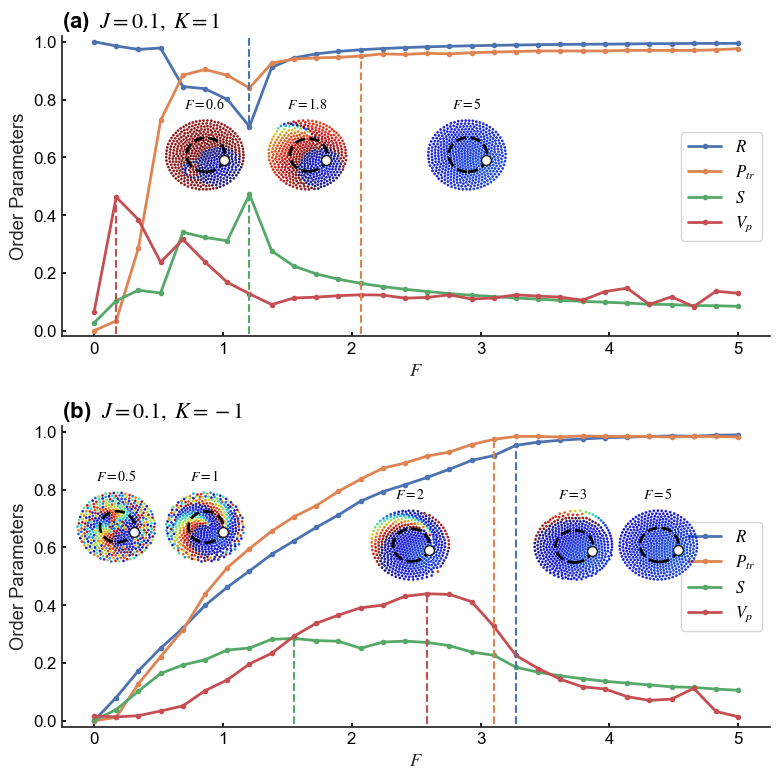

In [10]:
# For J = 0.1
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from copy import deepcopy
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 1, figsize=(8, 8))
ax1, ax2 = axs.flatten()
maps1[1].plot(ax=ax1, marker='.', label=r"$R$", lw=2)
maps2[1].plot(ax=ax1, marker='.', label=r"$P_{tr}$", lw=2)
maps3[1].plot(ax=ax1, marker='.', label=r"$S$", lw=2)
maps4[1].plot(ax=ax1, marker='.', label=r"$V_p$", lw=2)
# ax1.axvline(Fs[7], color='black', lw=1, linestyle='--')
# ax1.axvline(Fs[12], color='black', lw=1, linestyle='--')
xShift = 0
yloc = 0.45
wide = 0.6
axTide = inset_axes(ax1, width="20%", height="42%", loc='lower left',
                    bbox_to_anchor=(0.13 + xShift, yloc, wide, wide),
                    bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == 1][0]
StateAnalysis.plot_last_state(model, axTide, withColorBar=False, s=1, driveS=50)
axTide.set_title(r"$F=0.6$", fontweight="bold", fontsize=10)
axPaTrap = inset_axes(ax1, width="20%", height="42%", loc='lower left',
                    bbox_to_anchor=(0.275 + xShift, yloc, wide, wide),
                    bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == 1][0]
StateAnalysis.plot_last_state(model, axPaTrap, withColorBar=False, s=1, driveS=50)
axPaTrap.set_title(r"$F=1.8$", fontweight="bold", fontsize=10)
axGlTrap = inset_axes(ax1, width="20%", height="42%", loc='lower left',
                    bbox_to_anchor=(0.5 + xShift, yloc, wide, wide),
                    bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[29] and m.K == 1][0]
StateAnalysis.plot_last_state(model, axGlTrap, withColorBar=False, s=1, driveS=50)
axGlTrap.set_title(r"$F=5$", fontweight="bold", fontsize=10)
ax1.set_title("(a)" + r"$\ \ J=0.1,\ K=1$", fontweight="bold", loc="left", fontsize=16)
ax1.plot([maps1[1].idxmin(), maps1[1].idxmin()], [1.05, maps1[1].min()], color="C0", linestyle="--")
ax1.plot([Fs[12], Fs[12]], [-0.05, maps2[1][Fs[12]]], color="C1", linestyle="--")
ax1.plot([maps3[1].idxmax(), maps3[1].idxmax()], [-0.05, maps3[1].max()], color="C2", linestyle="--")
ax1.plot([maps4[1].idxmax(), maps4[1].idxmax()], [-0.05, maps4[1].max()], color="C3", linestyle="--")
ax1.set_ylim(-0.02, 1.02)

maps1[-1].plot(ax=ax2, marker='.', label=r"$R$", lw=2)
maps2[-1].plot(ax=ax2, marker='.', label=r"$P_{tr}$", lw=2)
maps3[-1].plot(ax=ax2, marker='.', label=r"$S$", lw=2)
maps4[-1].plot(ax=ax2, marker='.', label=r"$V_p$", lw=2)
# ax2.axvline(0.5, color='black', lw=1, linestyle='--')
# ax2.axvline(3.5, color='black', lw=1, linestyle='--')
ax21 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.005, 0.51, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax21, withColorBar=False, s=1, driveS=50)
ax21.set_title(r"$F=0.5$", fontweight="bold", fontsize=10)
ax22 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.13, 0.51, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax22, withColorBar=False, s=1, driveS=50)
ax22.set_title(r"$F=1$", fontweight="bold", fontsize=10)
ax23 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.42, 0.45, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[12] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax23, withColorBar=False, s=1, driveS=50)
ax23.set_title(r"$F=2$", fontweight="bold", fontsize=10)
ax24 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.65, 0.45, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[17] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax24, withColorBar=False, s=1, driveS=50)
ax24.set_title(r"$F=3$", fontweight="bold", fontsize=10)
ax25 = inset_axes(ax2, width="20%", height="42%", loc='lower left',
                  bbox_to_anchor=(0.77, 0.45, 0.6, 0.6),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[29] and m.K == -1][0]
StateAnalysis.plot_last_state(model, ax25, withColorBar=False, s=1, driveS=50)
ax25.set_title(r"$F=5$", fontweight="bold", fontsize=10)
ax2.set_title("(b)" + r"$\ \ J=0.1,\ K=-1$", fontweight="bold", loc="left", fontsize=16)
ax2.plot([Fs[19], Fs[19]], [-0.05, maps1[-1][Fs[19]]], color="C0", linestyle="--")
ax2.plot([Fs[18], Fs[18]], [-0.05, maps2[-1][Fs[18]]], color="C1", linestyle="--")
ax2.plot([maps3[-1].idxmax(), maps3[-1].idxmax()], [-0.05, maps3[-1].max()], color="C2", linestyle="--")
ax2.plot([maps4[-1].idxmax(), maps4[-1].idxmax()], [-0.05, maps4[-1].max()], color="C3", linestyle="--")
ax2.set_ylim(-0.02, 1.02)

for ax in axs.flatten():
    ax.set_xlabel(r"$F$", fontweight="bold")
    ax.set_ylabel("Order Parameters")
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.grid(False)
    ax.legend(loc="center right")
for subAx in [axTide, axPaTrap, axGlTrap, ax21, ax22, ax23, ax24, ax25]:
    subAx.set_xticks([])
    subAx.set_yticks([])
    subAx.patch.set_alpha(0)
    subAx.spines['right'].set_visible(False)
    subAx.spines['top'].set_visible(False)
    subAx.spines['bottom'].set_visible(False)
    subAx.spines['left'].set_visible(False)
    subAx.grid(False)

plt.tight_layout()
plt.savefig(f"./figs/formal/eps/orderParameterPlotJ{J}.eps", bbox_inches="tight")
plt.savefig(f"./figs/formal/png/orderParameterPlotJ{J}.png", bbox_inches="tight", dpi=200)

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


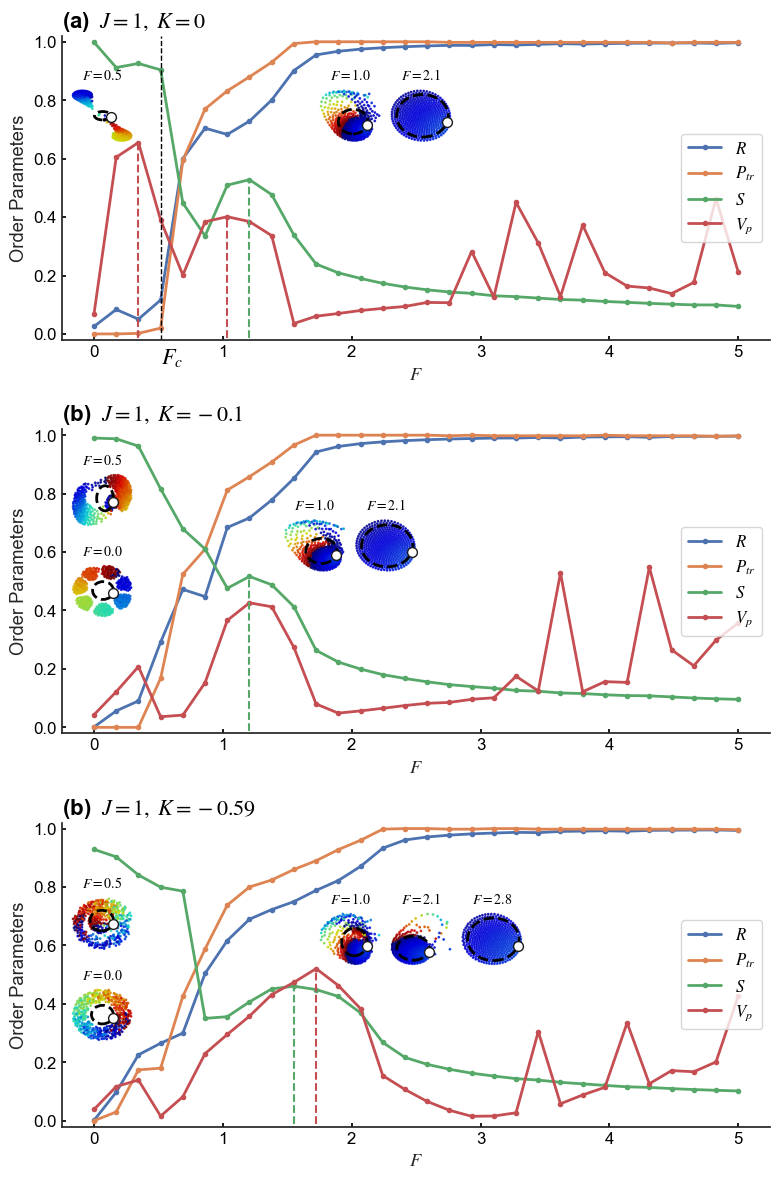

In [86]:
# For J=1
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from copy import deepcopy
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})
plt.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(3, 1, figsize=(8, 12))
ax1, ax2, ax3 = axs.flatten()
K1 = 0
maps1[K1].plot(ax=ax1, marker='.', label=r"$R$", lw=2)
maps2[K1].plot(ax=ax1, marker='.', label=r"$P_{tr}$", lw=2)
maps3[K1].plot(ax=ax1, marker='.', label=r"$S$", lw=2)
maps4[K1].plot(ax=ax1, marker='.', label=r"$V_p$", lw=2)
ax1.axvline(Fs[3], color='black', lw=1, linestyle='--')
ax1.text(Fs[3], -0.1, r"$F_c$", fontsize=16)
xShift = 0
yloc = 0.62
wide = 0.45
ax11 = inset_axes(ax1, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.0 + xShift, yloc, wide, wide),
                  bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == K1][0]
StateAnalysis.plot_last_state(model, ax11, withColorBar=False, s=1, driveS=50)
ax11.set_title(rf"$F={Fs[3]:.1f}$", fontweight="bold", fontsize=10)
ax12 = inset_axes(ax1, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.35 + xShift, yloc, wide, wide),
                  bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == K1][0]
StateAnalysis.plot_last_state(model, ax12, withColorBar=False, s=1, driveS=50)
ax12.set_title(rf"$F={Fs[6]:.1f}$", fontweight="bold", fontsize=10)
ax13 = inset_axes(ax1, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.45 + xShift, yloc, wide, wide),
                  bbox_transform=ax1.transAxes)
model = [m for m in models if m.F == Fs[12] and m.K == K1][0]
StateAnalysis.plot_last_state(model, ax13, withColorBar=False, s=1, driveS=50)
ax13.set_title(rf"$F={Fs[12]:.1f}$", fontweight="bold", fontsize=10)
ax1.set_title("(a)" + rf"$\ \ J=1,\ K={K1}$", fontweight="bold", loc="left", fontsize=16)
selectedS = maps3[K1][maps3[K1].index > 1]
ax1.plot([selectedS.idxmax(), selectedS.idxmax()], [-0.05, selectedS.max()], color="C2", linestyle="--")
ax1.plot([maps4[K1].idxmax(), maps4[K1].idxmax()], [-0.05, maps4[K1].max()], color="C3", linestyle="--")
selectedVp = maps4[K1][(maps4[K1].index > 0.8) & (maps4[K1].index < 2)]
ax1.plot([selectedVp.idxmax(), selectedVp.idxmax()], [-0.05, selectedVp.max()], color="C3", linestyle="--")
ax1.set_ylim(-0.02, 1.02)

K2 = Ks[13]
maps1[K2].plot(ax=ax2, marker='.', label=r"$R$", lw=2)
maps2[K2].plot(ax=ax2, marker='.', label=r"$P_{tr}$", lw=2)
maps3[K2].plot(ax=ax2, marker='.', label=r"$S$", lw=2)
maps4[K2].plot(ax=ax2, marker='.', label=r"$V_p$", lw=2)
yloc = 0.5
ax20 = inset_axes(ax2, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.0 + xShift, yloc - 0.15, wide, wide),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[0] and m.K == K2][0]
StateAnalysis.plot_last_state(model, ax20, withColorBar=False, s=1, driveS=50)
ax20.set_title(rf"$F={Fs[0]:.1f}$", fontweight="bold", fontsize=10)
ax21 = inset_axes(ax2, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.0 + xShift, yloc + 0.15, wide, wide),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == K2][0]
StateAnalysis.plot_last_state(model, ax21, withColorBar=False, s=1, driveS=50)
ax21.set_title(rf"$F={Fs[3]:.1f}$", fontweight="bold", fontsize=10)
ax22 = inset_axes(ax2, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.3 + xShift, yloc, wide, wide),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == K2][0]
StateAnalysis.plot_last_state(model, ax22, withColorBar=False, s=1, driveS=50)
ax22.set_title(rf"$F={Fs[6]:.1f}$", fontweight="bold", fontsize=10)
ax23 = inset_axes(ax2, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.4 + xShift, yloc, wide, wide),
                  bbox_transform=ax2.transAxes)
model = [m for m in models if m.F == Fs[12] and m.K == K2][0]
StateAnalysis.plot_last_state(model, ax23, withColorBar=False, s=1, driveS=50)
ax23.set_title(rf"$F={Fs[12]:.1f}$", fontweight="bold", fontsize=10)
ax2.set_title("(b)" + rf"$\ \ J=1,\ K={K2:.1f}$", fontweight="bold", loc="left", fontsize=16)
selectedS = maps3[K2][maps3[K2].index > 0.9]
ax2.plot([selectedS.idxmax(), selectedS.idxmax()], [-0.05, selectedS.max()], color="C2", linestyle="--")
ax2.set_ylim(-0.02, 1.02)

K3 = Ks[6]
maps1[K3].plot(ax=ax3, marker='.', label=r"$R$", lw=2)
maps2[K3].plot(ax=ax3, marker='.', label=r"$P_{tr}$", lw=2)
maps3[K3].plot(ax=ax3, marker='.', label=r"$S$", lw=2)
maps4[K3].plot(ax=ax3, marker='.', label=r"$V_p$", lw=2)

yloc = 0.5
ax30 = inset_axes(ax3, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.0 + xShift, yloc - 0.25, wide, wide),
                  bbox_transform=ax3.transAxes)
model = [m for m in models if m.F == Fs[0] and m.K == K3][0]
StateAnalysis.plot_last_state(model, ax30, withColorBar=False, s=1, driveS=50)
ax30.set_title(rf"$F={Fs[0]:.1f}$", fontweight="bold", fontsize=10)
ax31 = inset_axes(ax3, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.0 + xShift, yloc + 0.05, wide, wide),
                  bbox_transform=ax3.transAxes)
model = [m for m in models if m.F == Fs[3] and m.K == K3][0]
StateAnalysis.plot_last_state(model, ax31, withColorBar=False, s=1, driveS=50)
ax31.set_title(rf"$F={Fs[3]:.1f}$", fontweight="bold", fontsize=10)
ax32 = inset_axes(ax3, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.35 + xShift, yloc, wide, wide),
                  bbox_transform=ax3.transAxes)
model = [m for m in models if m.F == Fs[6] and m.K == K3][0]
StateAnalysis.plot_last_state(model, ax32, withColorBar=False, s=1, driveS=50)
ax32.set_title(rf"$F={Fs[6]:.1f}$", fontweight="bold", fontsize=10)
ax33 = inset_axes(ax3, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.45 + xShift, yloc, wide, wide),
                  bbox_transform=ax3.transAxes)
model = [m for m in models if m.F == Fs[12] and m.K == K3][0]
StateAnalysis.plot_last_state(model, ax33, withColorBar=False, s=1, driveS=50)
ax33.set_title(rf"$F={Fs[12]:.1f}$", fontweight="bold", fontsize=10)
ax34 = inset_axes(ax3, width="20%", height="40%", loc='lower left',
                  bbox_to_anchor=(0.55 + xShift, yloc, wide, wide),
                  bbox_transform=ax3.transAxes)
model = [m for m in models if m.F == Fs[16] and m.K == K3][0]
StateAnalysis.plot_last_state(model, ax34, withColorBar=False, s=1, driveS=50)
ax34.set_title(rf"$F={Fs[16]:.1f}$", fontweight="bold", fontsize=10)

ax3.set_title("(b)" + rf"$\ \ J=1,\ K={K3:.2f}$", fontweight="bold", loc="left", fontsize=16)
selectedS = maps3[K3][maps3[K3].index > 0.8]
ax3.plot([selectedS.idxmax(), selectedS.idxmax()], [-0.05, selectedS.max()], color="C2", linestyle="--")
ax3.plot([maps4[K3].idxmax(), maps4[K3].idxmax()], [-0.05, maps4[K3].max()], color="C3", linestyle="--")
ax3.set_ylim(-0.02, 1.02)

for ax in axs.flatten():
    ax.set_xlabel(r"$F$", fontweight="bold")
    ax.set_ylabel("Order Parameters")
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(direction='in', length=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.grid(False)
    ax.legend(loc="center right")
for subAx in [ax11, ax12, ax13, ax20, ax21, ax22, ax23, ax30, ax31, ax32, ax33, ax34]:
    subAx.set_xticks([])
    subAx.set_yticks([])
    subAx.patch.set_alpha(0)
    subAx.spines['right'].set_visible(False)
    subAx.spines['top'].set_visible(False)
    subAx.spines['bottom'].set_visible(False)
    subAx.spines['left'].set_visible(False)
    subAx.grid(False)

plt.tight_layout()
plt.savefig(f"./figs/formal/eps/orderParameterPlotJ{J}.eps", bbox_inches="tight")
plt.savefig(f"./figs/formal/png/orderParameterPlotJ{J}.png", bbox_inches="tight", dpi=200)

In [73]:
K3 = Ks[4]
F = Fs[4]
model = [m for m in models if m.F == F and m.K == K3][0]
Iatt, Irep, Fatt, Frep = model.Iatt, model.Irep, model.Fatt, model.Frep
dim = Iatt.shape[0]
pointX = np.sum(
    Iatt * Fatt.reshape((dim, dim, 1)) - Irep * Frep.reshape((dim, dim, 1)),
    axis=1
) / dim # * model.dt
phi = np.arctan2(pointX[:, 1], pointX[:, 0])
np.abs(np.sum(np.exp(1j * phi))) / model.agentsNum, K3, F

(0.11216562426555093, -0.7241379310344828, 0.6896551724137931)

In [18]:
opK1 = pd.concat([
    maps1[1],
    maps2[1],
    maps3[1],
    maps4[1]
], axis=1, keys=["R", "P_tr", "S", "V_p"])
opK1.index.name = "F"
opK1.to_excel(f"./figs/formal/orderParameterPlotJ{J}K1.xlsx")
opK_1 = pd.concat([
    maps1[-1],
    maps2[-1],
    maps3[-1],
    maps4[-1]
], axis=1, keys=["R", "P_tr", "S", "V_p"])
opK_1.index.name = "F"
opK_1.to_excel(f"./figs/formal/orderParameterPlotJ{J}K-1.xlsx")